In [106]:
import sys
sys.path.insert(0, '../pyLDLE2/')

In [107]:
import numpy as np
from pyLDLE2 import util_, visualize_, datasets
from scipy.sparse import coo_matrix
from scipy import optimize
from scipy.special import erf
from matplotlib import pyplot as plt

In [108]:
vis = visualize_.Visualize()

In [109]:
X, labelsMat, ddX = datasets.Datasets().circular_disk(RES=50, noise=0.0025, noise_type='normal')

X.shape =  (7825, 3)


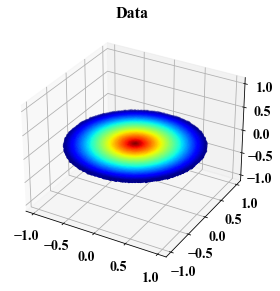

In [110]:
vis.data(X, ddX)

In [111]:
k_nn = 49
neigh_dist, neigh_ind = util_.nearest_neighbors(X, k_nn, metric='euclidean')

In [112]:
h = 0.05
K = np.exp(-neigh_dist**2/h**2)

In [113]:
n = X.shape[0]
source_ind = np.repeat(np.arange(n),neigh_ind.shape[1])
K = coo_matrix((K.flatten(),(source_ind, neigh_ind.flatten())),shape=(n,n))
ones_K_like = coo_matrix((np.ones(neigh_dist.shape).flatten(),(source_ind, neigh_ind.flatten())),shape=(n,n))

# symmetrize
K = K + K.T
ones_K_like = ones_K_like + ones_K_like.T
K.data /= ones_K_like.data

In [114]:
mu_hN_norm = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    temp = X-X[i,:][None,:]
    mu_hN_norm[i] = np.linalg.norm(K.getrow(i).dot(temp))

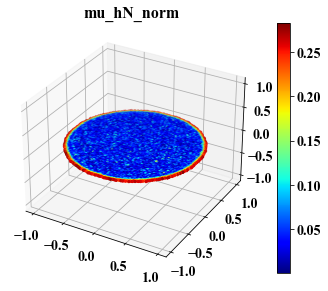

In [115]:
vis.data(X, mu_hN_norm, title='mu_hN_norm', colorbar=True)

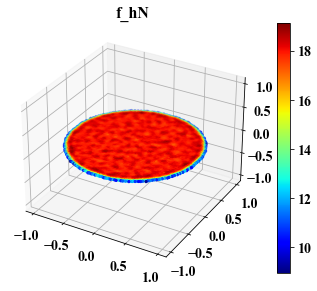

In [116]:
vis.data(X, np.array(K.sum(axis=1)).flatten(), title='f_hN', colorbar=True)

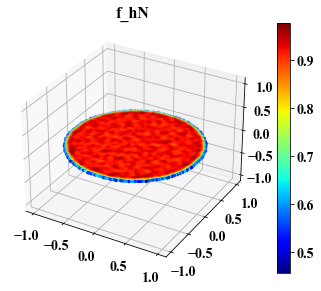

In [125]:
vis.data(X, np.array(K.sum(axis=1)).flatten()/(n*h**2), title='f_hN', colorbar=True)

In [117]:
c_num = h*np.array(K.sum(axis=1)).flatten()/np.sqrt(np.pi)
c_denom = mu_hN_norm
c = c_num/(c_denom+1e-20)

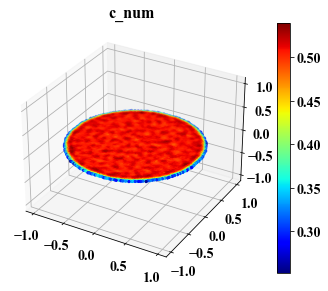

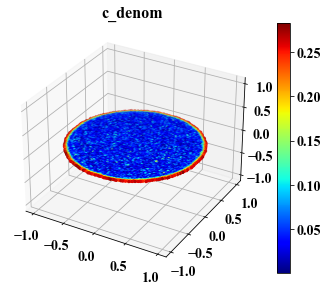

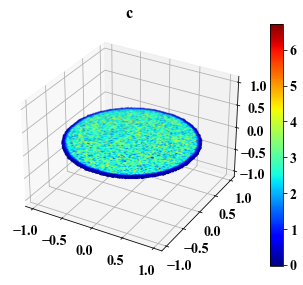

In [118]:
vis.data(X, c_num, title='c_num', colorbar=True)
vis.data(X, c_denom, title='c_denom', colorbar=True)
vis.data(X, np.log(c), title='c', colorbar=True)

In [119]:
def F(x):
    return c_denom*(1+erf(x/h))*np.exp(x**2/h**2)-c_num

def F_prime(x):
    return (c_denom/h)*(2/np.sqrt(np.pi) + 2*(1+erf(x/h))*np.exp(x**2/h**2)*x/h)

In [120]:
bx_init = h*np.sqrt(np.maximum(0, -np.log(2*c_denom+1e-30)+np.log(c_num+1e-30)))

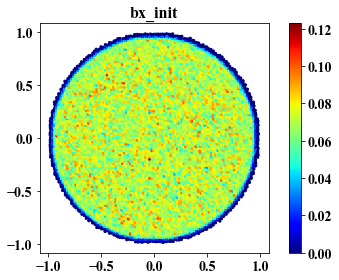

In [121]:
vis.data(X[:,:2], bx_init, title='bx_init', colorbar=True)

In [122]:
bx = optimize.newton(F, bx_init, F_prime, maxiter=50)

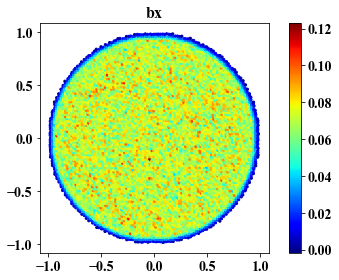

In [123]:
vis.data(X[:,:2], bx, title='bx', colorbar=True)

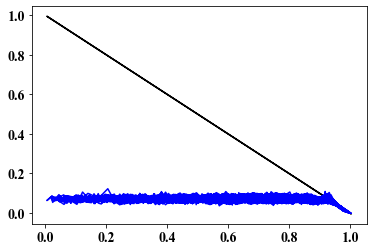

In [124]:
plt.plot(np.linalg.norm(X[:,:2], axis=1), ddX, color='k', label='True $b_x$')
plt.plot(np.linalg.norm(X[:,:2], axis=1), bx, color='b', label='est $b_x$')